In [68]:
%matplotlib ipympl
import scipy.signal as signal
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import RectangleSelector
import skimage.util
import scipy.ndimage as ndimage
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.io import imread
import matplotlib
import skimage.restoration as restoration
from typing import Dict

import skimage.filters.rank as rank
plt.gray()
def PSNR(f,g):
    return 10*np.log10(1.0/ np.mean(np.square(f-g)))


class Selector:
    def __init__(self, ax):
        self.RS = RectangleSelector(ax, self.line_select_callback,
                                     useblit=True,
                                       button=[1, 3],  
                                       minspanx=5, minspany=5,
                                       spancoords='pixels',
                                       interactive=True)
        self.bbox = [None, None, None, None]
        
    def line_select_callback(self,eclick, erelease):
        'eclick and erelease are the press and release events'
        x1, y1 = eclick.xdata, eclick.ydata
        x2, y2 = erelease.xdata, erelease.ydata
        self.bbox = [int(y1), int(y2), int(x1), int(x2)]
    def get_bbox(self):
        return self.bbox

f = imread('cameraman.tif').astype(np.float64)/255
I = imread('degraded.tif').astype(np.float64)/255

def plot_images(images: Dict[str, np.ndarray], title=None, cmap='None'):
    """Plots all images in a row""",
    fig = plt.figure(figsize=(10, 3))
    for index, (subtitle, image) in enumerate(images.items(), 1):
        ax = fig.add_subplot(1, len(images), index)
        if cmap == 'gray':
            ax.imshow(image, cmap='gray')
        else:
            ax.imshow(image)
        ax.title.set_text(subtitle)
    if title:
        fig.suptitle(title)
    plt.show()


# Part 2: Image Restoration in the Frequency Domain

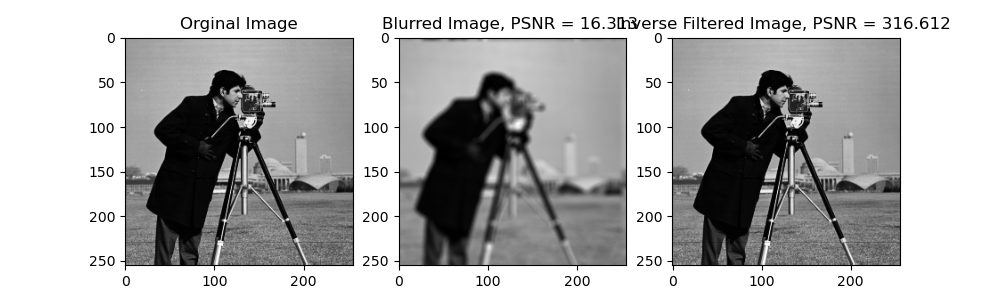

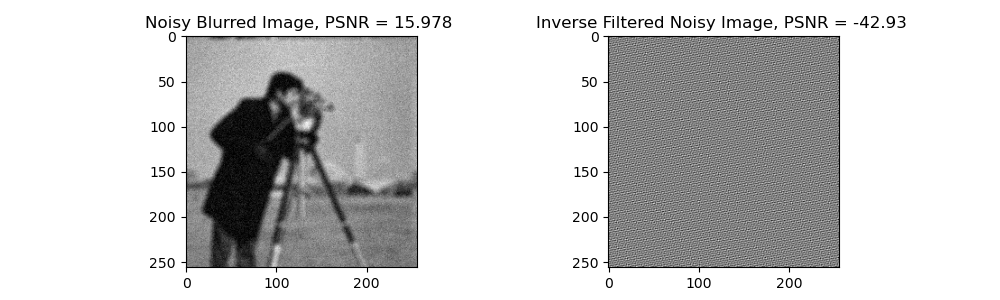

0.03346258505967787


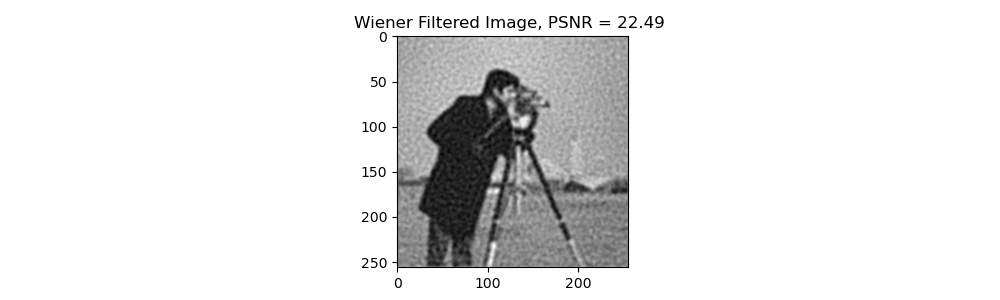

In [69]:
# Let us now study two frequency domain based image restoration methods: inverse filtering and Wiener filtering. Load the Camerman image (adjust intensities to range of 0 to 1). First, create a disk blur function of radius of 4 and apply it to the image in the frequency domain:

h_d = disk(4)
h = np.zeros((256,256))
h[0:9,0:9] = h_d / np.sum(h_d)

h = np.roll(h, (-5,-5)) 
h_freq = np.fft.fft2(h)
f_blurfreq = h_freq*np.fft.fft2(f)
f_blur = np.real(np.fft.ifft2(f_blurfreq))

# plot h_freq
# plt.figure()
# plt.imshow(np.log(np.abs(np.fft.fftshift(h_freq))), cmap='gray')
# plt.title('h_freq')
# plt.show()

# Plot the blurred image and the corresponding PSNR. Now apply inverse filtering to it by dividing the image by the blurring function h freq and plot the result.

blurred_psnr = round(PSNR(f, f_blur), 3)

f_invfreq = f_blurfreq / h_freq
f_inv = np.real(np.fft.ifft2(f_invfreq))

inv_psnr = round(PSNR(f, f_inv), 3)

plot_images({'Orginal Image': f,f'Blurred Image, PSNR = {blurred_psnr} ': f_blur, f'Inverse Filtered Image, PSNR = {inv_psnr} ': f_inv}, cmap='gray')

# Now add zero-mean Gaussian noise with a variance of 0.002 to the blurred image using skimage.util.random noise. Apply inverse filtering to the noisy blurred image. Plot the restored image and the PSNR.

noise_variance = 0.002
f_blur_noisy = skimage.util.random_noise(f_blur, mode='gaussian', var=noise_variance)
f_blur_noisy_freq = np.fft.fft2(f_blur_noisy)
f_inv_noisy_freq = f_blur_noisy_freq / h_freq
f_inv_noisy = np.real(np.fft.ifft2(f_inv_noisy_freq))

noisy_psnr = round(PSNR(f, f_blur_noisy), 3)
inv_noisy_psnr = round(PSNR(f, f_inv_noisy), 3)

plot_images({f'Noisy Blurred Image, PSNR = {noisy_psnr} ': f_blur_noisy, f'Inverse Filtered Noisy Image, PSNR = {inv_noisy_psnr} ': f_inv_noisy}, cmap='gray')

# Let us study the Wiener filter for image restoration. Apply Wiener filtering on the noisy blurred image used in the previous step. Use the restoration.wiener function and pass in the disk blur function as the point-spread function (PSF) and an appropriate approximation of noise-to-signal ratio (NSR). Note, that restoration.wiener expects the PSF to be centered, so be sure to do this with np.fft.fftshift.

# approximate NSR using variance of the noise and the variance of the original image
NSR_approx = noise_variance / np.var(f)

print(NSR_approx)
f_wiener = restoration.wiener(f_blur_noisy, psf=np.fft.fftshift(h), balance=NSR_approx)

wiener_psnr = round(PSNR(f, f_wiener), 3)

plot_images({f'Wiener Filtered Image, PSNR = {wiener_psnr} ': f_wiener}, cmap='gray')


# Part 3: Adaptive Filtering

0.010137759640287973


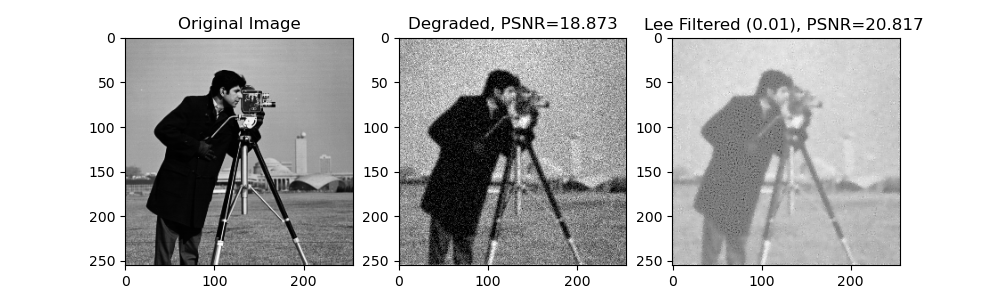

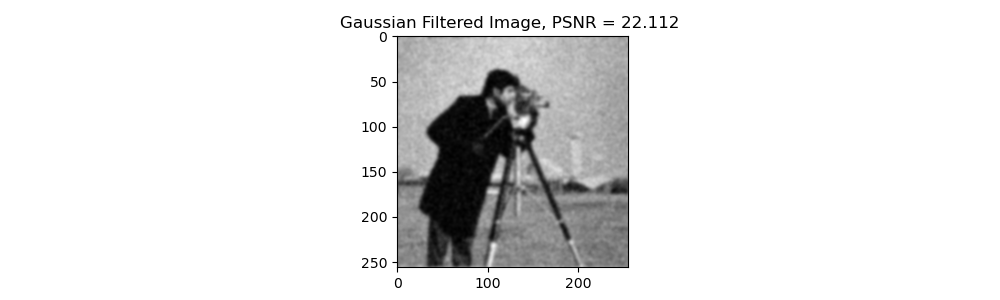

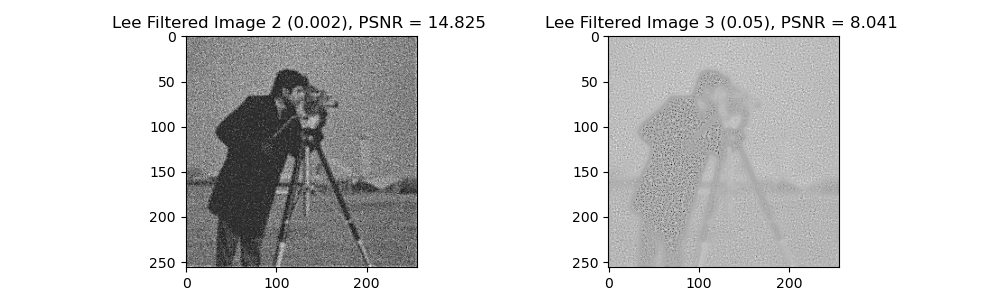

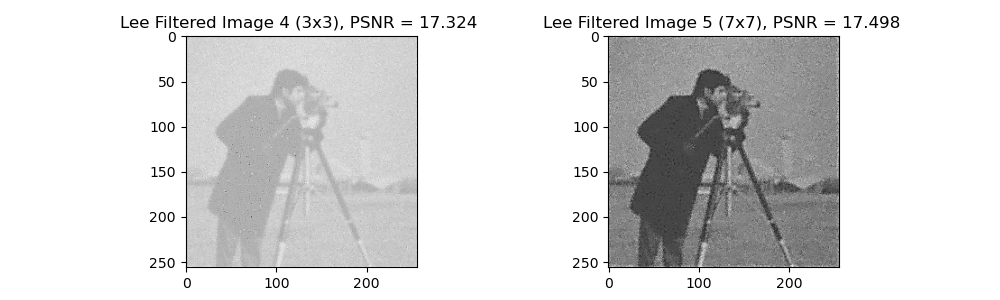

In [90]:
# Let us now study noise reduction using Lee filter. Load degraded.tif and adjust intensities between [0,1].

# Load the image and adjust intensities
## already done above

# Use a flat region of degraded.tif and estimate the variance of the noise (Use the provided Selector class, see the example usage in selector ex.py/selector ex.ipynb).

# Plot the selected region and compute the variance of the noise.
# [20, 62, 184, 229], theses are the values I got from the selector, from a helper function I wrote in selector_ex.py
selected_region = I[20:62, 184:229]
# Compute the variance of the selected region
noise_variance3 = np.var(selected_region)
print(noise_variance3)

# # Apply Lee filter with a window size of 5x5 and plot the result.
mn = np.ones((5,5))/25
local_mean = signal.convolve(I, mn, mode="same")
local_var = signal.convolve(I**2, mn, mode="same") - local_mean**2

# # # compute elements of matrix K and denoise the image using Lee formulation.
K = (local_var - noise_variance3) / local_var

# Plot the original and denoised image, with PSNR.
I_lee = K * I + (1 - K) * local_mean
lee_psnr = round(PSNR(f, I_lee), 3)
degraded_psnr = round(PSNR(f, I), 3)

plot_images({f'Original Image': f, f'Degraded, PSNR={degraded_psnr}': I, f'Lee Filtered (0.01), PSNR={lee_psnr} ': I_lee}, cmap='gray')

 #  Compare this result to that using a Gaussian low pass filter with standard deviation of 30. Plot the result and the PSNR.
def gaussian_filter(n_rows, n_cols, stdv):
    """
    Returns a 2d Gaussian image filter.
    """
    g_r = signal.windows.gaussian(n_rows, stdv)
    g_c = signal.windows.gaussian(n_cols, stdv)

    G = np.outer(g_r, g_c)

    return G/np.sum(G)

# Create the Gaussian filter
M, N = I.shape
sigma = 30
H = gaussian_filter(M, N, sigma)
H = H/H.max()

F_cameraman = np.fft.fftshift(np.fft.fft2(I))
filtered_F_cameraman = F_cameraman * H
# Take the inverse Fourier transform, and display the blurred image with PSNR
filtered_cameraman = np.real(np.fft.ifft2(np.fft.ifftshift(filtered_F_cameraman)))
gaussian_psnr = round(PSNR(f, filtered_cameraman), 3)
plot_images({f'Gaussian Filtered Image, PSNR = {gaussian_psnr} ': filtered_cameraman}, cmap='gray')

# 8. Try varying your estimate of the noise variance both above and below the value you got from your flat region. How does this change the filter’s results? Why?
noise_variance4 = 0.002
K2 = (local_var - noise_variance4) / local_var
noise_variance5 = 0.05
K3 = (local_var - noise_variance5) / local_var

I_lee2 = I + K2 * (I - local_mean)
I_lee3 = I + K3 * (I - local_mean)
lee2_psnr = round(PSNR(f, I_lee2), 3)
lee3_psnr = round(PSNR(f, I_lee3), 3)
plot_images({f'Lee Filtered Image 2 (0.002), PSNR = {lee2_psnr} ': I_lee2, f'Lee Filtered Image 3 (0.05), PSNR = {lee3_psnr} ': I_lee3}, cmap='gray')

# 9. Try changing the size of the filter neighborhood to be smaller and larger than 5 ×5. How does this change the results? Why?
mn2 = np.ones((3,3))/9
local_mean2 = signal.convolve(I, mn2, mode="same")
local_var2 = signal.convolve(I**2, mn2, mode="same") - local_mean2**2
K4 = (local_var2 - noise_variance3) / local_var2
I_lee4 = I + K4 * (I - local_mean2)
lee4_psnr = round(PSNR(f, I_lee4), 3)

mn3 = np.ones((7,7))/49
local_mean3 = signal.convolve(I, mn3, mode="same")
local_var3 = signal.convolve(I**2, mn3, mode="same") - local_mean3**2
K5 = (local_var3 - noise_variance3) / local_var3
I_lee5 = I + K5 * (I - local_mean3)
lee5_psnr = round(PSNR(f, I_lee5), 3)

plot_images({f'Lee Filtered Image 4 (3x3), PSNR = {lee4_psnr} ': I_lee4, f'Lee Filtered Image 5 (7x7), PSNR = {lee5_psnr} ': I_lee5}, cmap='gray')